In [2097]:
import pandas as pd
import numpy as np

In [2098]:
import torch
from torchsummary import summary

In [2099]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2100]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2101]:
import kagglehub
rabieelkharoua_students_performance_dataset_path = kagglehub.dataset_download('rabieelkharoua/students-performance-dataset')

print('Data source import complete.')

print(rabieelkharoua_students_performance_dataset_path)

Data source import complete.
/home/michael/.cache/kagglehub/datasets/rabieelkharoua/students-performance-dataset/versions/2


In [2102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2103]:
df = pd.read_csv(rabieelkharoua_students_performance_dataset_path + '/Student_performance_data _.csv')

In [2104]:
print(df.head())

   StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0       1001   17       1          0                  2        19.833723   
1       1002   18       0          0                  1        15.408756   
2       1003   15       0          2                  3         4.210570   
3       1004   17       1          0                  3        10.028829   
4       1005   17       1          0                  2         4.672495   

   Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
0         7         1                2                0       0      1   
1         0         0                1                0       0      0   
2        26         0                2                0       0      0   
3        14         0                3                1       0      0   
4        17         1                3                0       0      0   

   Volunteering       GPA  GradeClass  
0             0  2.929196         2.0  
1             0  3

In [2105]:
df = df.drop(columns=['StudentID'])
df = df.drop(columns=['GPA'])
print(df.shape)

(2392, 13)


In [2106]:
print(df.isna().sum())

Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GradeClass           0
dtype: int64


In [2107]:
for col in df.columns:
    print(col, df[col].unique())

Age [17 18 15 16]
Gender [1 0]
Ethnicity [0 2 1 3]
ParentalEducation [2 1 3 4 0]
StudyTimeWeekly [19.83372281 15.40875606  4.21056977 ...  6.80549964 12.41665266
 17.81990749]
Absences [ 7  0 26 14 17 10 22  1 11 15 21  9 16 29  2 25 20  5  8 12 27 23  3 13
  6 28  4 18 19 24]
Tutoring [1 0]
ParentalSupport [2 1 3 4 0]
Extracurricular [0 1]
Sports [0 1]
Music [1 0]
Volunteering [0 1]
GradeClass [2. 1. 4. 3. 0.]


In [2108]:
df['Ethnicity'] = df['Ethnicity'].map({0: 'Caucasian', 1: 'African American', 2: 'Asian', 3: 'Other'})
work_onehot = pd.get_dummies(df['Ethnicity'], prefix='Ethnicity', dtype=float)
df = pd.concat([df.drop('Ethnicity', axis=1), work_onehot], axis=1)

df['ParentalEducation'] = df['ParentalEducation'].map({0: 'None', 1: 'High School', 2: 'Some College', 3: "Bachelor's", 4: 'Higher'})
work_onehot = pd.get_dummies(df['ParentalEducation'], prefix='ParentalEducation', dtype=float)
df = pd.concat([df.drop('ParentalEducation', axis=1), work_onehot], axis=1)

In [2109]:
for col in df.columns:
    print(col, df[col].unique())

Age [17 18 15 16]
Gender [1 0]
StudyTimeWeekly [19.83372281 15.40875606  4.21056977 ...  6.80549964 12.41665266
 17.81990749]
Absences [ 7  0 26 14 17 10 22  1 11 15 21  9 16 29  2 25 20  5  8 12 27 23  3 13
  6 28  4 18 19 24]
Tutoring [1 0]
ParentalSupport [2 1 3 4 0]
Extracurricular [0 1]
Sports [0 1]
Music [1 0]
Volunteering [0 1]
GradeClass [2. 1. 4. 3. 0.]
Ethnicity_African American [0. 1.]
Ethnicity_Asian [0. 1.]
Ethnicity_Caucasian [1. 0.]
Ethnicity_Other [0. 1.]
ParentalEducation_Bachelor's [0. 1.]
ParentalEducation_High School [0. 1.]
ParentalEducation_Higher [0. 1.]
ParentalEducation_None [0. 1.]
ParentalEducation_Some College [1. 0.]


In [2110]:
print(df.shape)

(2392, 20)


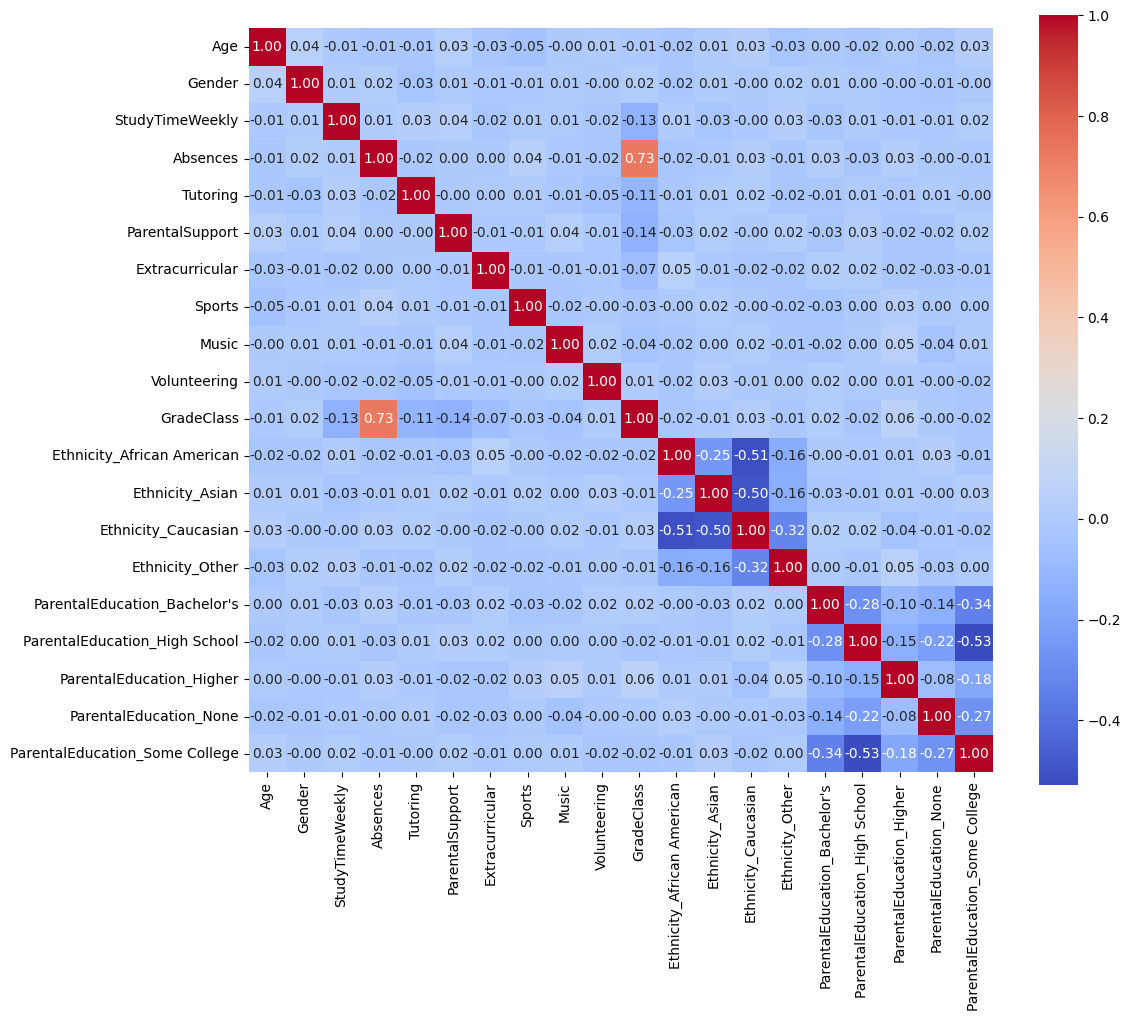

In [2111]:
correlation_matrix = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.show()

In [2112]:
target = df['GradeClass'].values
df = df[['GradeClass', 'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'ParentalEducation_Higher']]
features = df.drop(columns=['GradeClass']).values
print(features.shape)
# Стандартизация признаков
scaler = StandardScaler()
features = scaler.fit_transform(features)

(2392, 6)


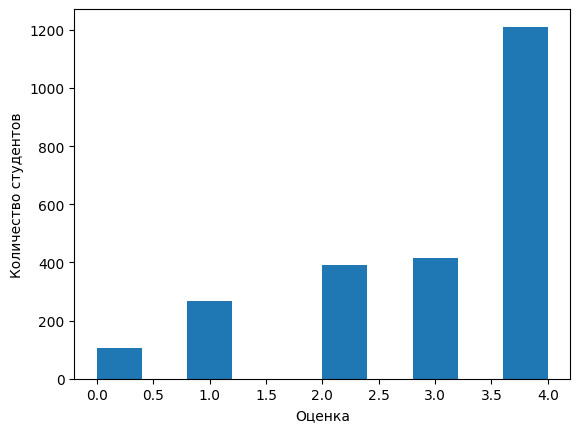

In [2113]:
# Диаграмма для анализа распределения оценок
plt.hist(target)
plt.xlabel("Оценка")
plt.ylabel("Количество студентов")
plt.show()

In [2114]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(target), y=target)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

print(class_weights)

tensor([4.4710, 1.7784, 1.2235, 1.1556, 0.3950], device='cuda:0')


In [2115]:
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(target, dtype=torch.long)

In [2116]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, random_state=42, test_size=0.1)

In [2117]:
train_idx, test_idx = train_test_split(range(len(target)), test_size=0.2, random_state=42)

dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
train_data = torch.utils.data.Subset(dataset, train_idx)
test_data = torch.utils.data.Subset(dataset, test_idx)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [2118]:
class Net(torch.nn.Module):
    def __init__(self, train_loader, test_loader, device):
        super(Net, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(6, 256),
            torch.nn.Dropout(0.3),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.Dropout(0.3),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 5)
        )

        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device

    def forward(self, x):
        return self.layers(x)

    def train_model(self, optimizer, criterion, num_epochs):
        self.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            all_targets = []
            all_predictions = []
            
            for inputs, labels in self.train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                
                all_targets.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
            
            epoch_loss = running_loss / len(self.train_loader)
            
            train_report = classification_report(
                all_targets,
                all_predictions,
                target_names=['F', 'D', 'C', 'B', 'A'],
                output_dict=True,
                zero_division=0
            )
            
            train_accuracy = train_report['accuracy']
            train_f1_macro = train_report['macro avg']['f1-score']
            train_f1_weighted = train_report['weighted avg']['f1-score']
            
            test_loss, test_accuracy, test_f1_macro, test_f1_weighted, class_f1 = self.evaluate_model(criterion)
            
            print(f'\nEpoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {epoch_loss:.4f} | Acc: {train_accuracy:.4f} | F1 (macro): {train_f1_macro:.4f} | F1 (weighted): {train_f1_weighted:.4f}')
            print(f'Test  Loss: {test_loss:.4f} | Acc: {test_accuracy:.4f} | F1 (macro): {test_f1_macro:.4f} | F1 (weighted): {test_f1_weighted:.4f}')
            
            print('\nClass-wise Test F1:')
            for class_name, f1 in class_f1.items():
                print(f'{class_name}: {f1:.4f}', end=' | ')
            print('\n' + '-'*50)


    def evaluate_model(self, criterion):
        self.eval()
        all_targets = []
        all_predictions = []
        running_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                
                all_targets.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
        
        test_loss = running_loss / len(self.test_loader)
        
        report = classification_report(
            all_targets, 
            all_predictions,
            target_names=['F', 'D', 'C', 'B', 'A'],
            output_dict=True,
            zero_division=0
        )
        
        test_accuracy = report['accuracy']
        test_f1_macro = report['macro avg']['f1-score']
        test_f1_weighted = report['weighted avg']['f1-score']
        
        class_f1 = {f'f1_{k}': v['f1-score'] for k, v in report.items() if k in ['F', 'D', 'C', 'B', 'A']}
        
        return test_loss, test_accuracy, test_f1_macro, test_f1_weighted, class_f1

    def show_results(self):
        self.eval()
        with torch.no_grad():
            outputs = []
            targets = []
            for inputs, labels in self.test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                _, predicted = torch.max(self(inputs).data, 1)
                outputs.append(predicted.squeeze())
                targets.append(labels)

        targets_tensor = torch.cat(targets).cpu().numpy()
        outputs_tensor = torch.cat(outputs).cpu().numpy()

        plt.figure(figsize=(10, 6))
        plt.plot(targets_tensor[:25], alpha=0.3, label='Целевое значение', color='green', linestyle='none', marker='o')
        plt.plot(outputs_tensor[:25], alpha=0.3, label='Предсказания', color='red', linestyle='none', marker='o')
        plt.ylabel("Оценка")
        plt.legend()
        plt.grid()
        plt.ylim(-0.1, 4.1)
        plt.show()

        errors_mask = targets_tensor != outputs_tensor
        correct_mask = targets_tensor == outputs_tensor

        incorrect_targets = targets_tensor[errors_mask]
        correct_targets = targets_tensor[correct_mask]

        error_counts = np.bincount(incorrect_targets.astype(int), minlength=5)
        correct_counts = np.bincount(correct_targets.astype(int), minlength=5)

        plt.figure(figsize=(10, 6))
        plt.bar(range(5), error_counts, color='orange', alpha=0.5, label='Ошибки')
        plt.bar(range(5), correct_counts, color='green', alpha=0.5, bottom=error_counts, label='Верные прогнозы')
        plt.xlabel('Класс')
        plt.ylabel('Количество ошибок')
        plt.title('Распределение правильных и ошибочных прогнозов по классам')
        plt.xticks(range(5), ['F', 'D', 'C', 'B', 'A'])
        plt.legend(loc='upper left')
        plt.grid(axis='y')
        plt.show()

        print(classification_report(targets_tensor, outputs_tensor))
        print("\nConfusion Matrix:")
        print(confusion_matrix(targets_tensor, outputs_tensor))

        sns.heatmap(confusion_matrix(targets_tensor, outputs_tensor), 
                    annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')

In [2119]:
model = Net(train_loader, test_loader, device).to(device)
print(summary(model, (1, 6)))

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]           1,792
           Dropout-2               [-1, 1, 256]               0
              ReLU-3               [-1, 1, 256]               0
            Linear-4               [-1, 1, 256]          65,792
           Dropout-5               [-1, 1, 256]               0
              ReLU-6               [-1, 1, 256]               0
            Linear-7                 [-1, 1, 5]           1,285
Total params: 68,869
Trainable params: 68,869
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.26
Estimated Total Size (MB): 0.27
----------------------------------------------------------------
None


In [2120]:
model.train_model(optimizer, criterion, 50)


Epoch [1/50]
Train Loss: 1.5035 | Acc: 0.5609 | F1 (macro): 0.3446 | F1 (weighted): 0.5425
Test  Loss: 1.3705 | Acc: 0.6075 | F1 (macro): 0.3634 | F1 (weighted): 0.5784

Class-wise Test F1:
f1_F: 0.0000 | f1_D: 0.3850 | f1_C: 0.3407 | f1_B: 0.1947 | f1_A: 0.8966 | 
--------------------------------------------------

Epoch [2/50]
Train Loss: 1.2951 | Acc: 0.6299 | F1 (macro): 0.4390 | F1 (weighted): 0.6233
Test  Loss: 1.2534 | Acc: 0.6200 | F1 (macro): 0.4400 | F1 (weighted): 0.6252

Class-wise Test F1:
f1_F: 0.2069 | f1_D: 0.2535 | f1_C: 0.3857 | f1_B: 0.4712 | f1_A: 0.8827 | 
--------------------------------------------------

Epoch [3/50]
Train Loss: 1.2267 | Acc: 0.6487 | F1 (macro): 0.4924 | F1 (weighted): 0.6579
Test  Loss: 1.2147 | Acc: 0.5887 | F1 (macro): 0.4463 | F1 (weighted): 0.6096

Class-wise Test F1:
f1_F: 0.2424 | f1_D: 0.3178 | f1_C: 0.3742 | f1_B: 0.4513 | f1_A: 0.8460 | 
--------------------------------------------------

Epoch [4/50]
Train Loss: 1.1814 | Acc: 0.6581

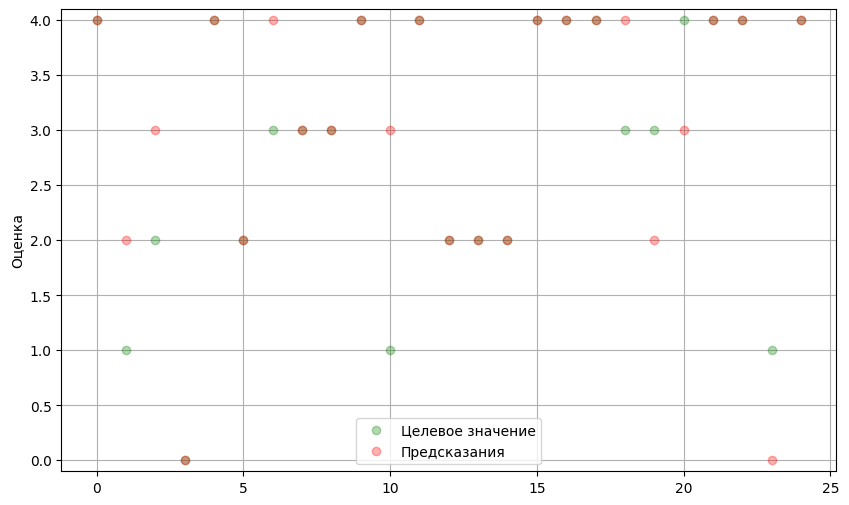

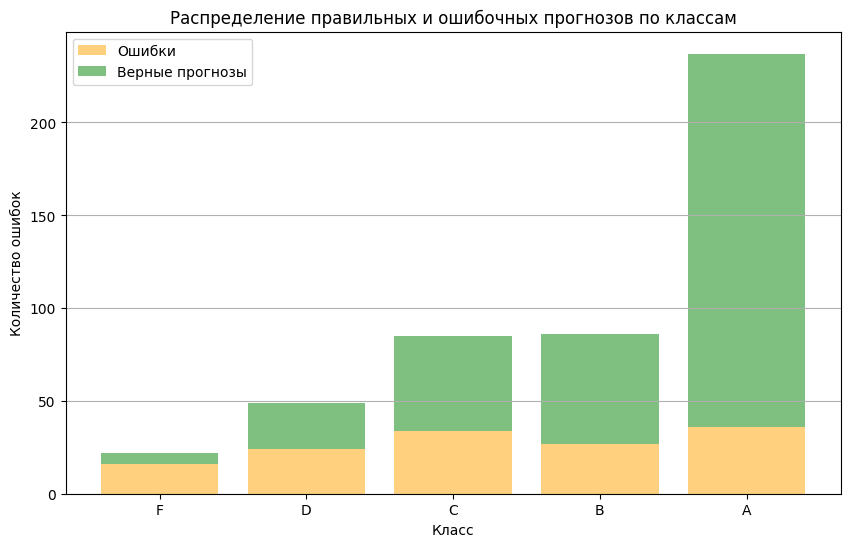

              precision    recall  f1-score   support

           0       0.26      0.27      0.27        22
           1       0.50      0.51      0.51        49
           2       0.65      0.60      0.62        85
           3       0.56      0.69      0.61        86
           4       0.91      0.85      0.88       237

    accuracy                           0.71       479
   macro avg       0.57      0.58      0.58       479
weighted avg       0.73      0.71      0.72       479


Confusion Matrix:
[[  6   9   3   2   2]
 [  8  25  11   2   3]
 [  0  13  51  17   4]
 [  0   3  13  59  11]
 [  9   0   1  26 201]]


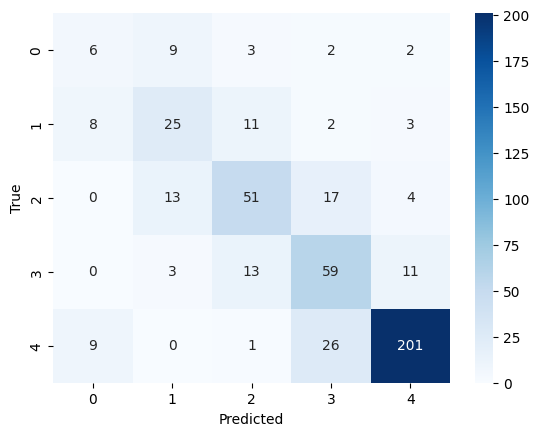

In [2121]:
model.show_results()